In [8]:
import numpy as np
#! pip install pygad
import pygad.gann
#!pip install sklearn
from sklearn import preprocessing
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
#restart anaconda/jupyterlab
from ipywidgets import widgets
from IPython.display import display, clear_output

from math import fabs as fabs
import matplotlib.pyplot as plt
import math
from PIL import Image

In [9]:
mincolor = (0,0,1)
midcolor = (.95,.95,.95)
maxcolor = (1,0,0)

# A map of rgb points in your distribution
# [distance, (r, g, b)]
# distance is percentage from left edge
heatmap = [
    [0.0, mincolor],
    [0.5, midcolor],
    [1.00, maxcolor],
]

width, height = 500, 50

def gaussian(x, a, b, c, d=0):
    return a * math.exp(-(x - b)**2 / (2 * c**2)) + d

def pixel(x, width=100, map=[], spread=1):
    width = float(width)
    r = sum([gaussian(x, p[1][0], p[0] * width, width/(spread*len(map))) for p in map])
    g = sum([gaussian(x, p[1][1], p[0] * width, width/(spread*len(map))) for p in map])
    b = sum([gaussian(x, p[1][2], p[0] * width, width/(spread*len(map))) for p in map])
    return min(1.0, r), min(1.0, g), min(1.0, b)

def drawLegend():
    im = Image.new('RGB', (width, height))
    ld = im.load()

    for x in range(im.size[0]):
        r, g, b = pixel(x, width=im.size[0], map=heatmap)
        r, g, b = [int(256*v) for v in (r, g, b)]
        for y in range(im.size[1]):
            ld[x, y] = r, g, b

    im.save('grad.png')
    display(im)

In [10]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes, solution):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    #normalized = solution + np.absolute(np.min(solution))
    maxsol = np.max(np.absolute(solution))
    normalized = solution / maxsol
    normalizedWidth = normalized * ((width/2)-1)
    
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    i = 0
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing])
                if solution[i] >= 0:
                    r, g, b = pixel(np.absolute(normalizedWidth[i]+(width/2)), width=width, map=heatmap)
                    line.set_color((r,g,b, 1))
                else:
                    r, g, b = pixel((width/2)-np.absolute(normalizedWidth[i]), width=width, map=heatmap)
                    line.set_color((r,g,b, 1))
                i += 1
                ax.add_artist(line)

In [19]:
#solutions_num - liczba rozwiązań np. 5
#input_num - liczba neuronów w warstwie wejściowej np. 3
#hidden_num - ilość neuronów w warstwach ukrytych np. [2] lub [5, 2]
#output_num - liczba neuronów w warstwie wyjściowej np. 1
#hidden_act - rodzaj funkcji aktywacji dla warstw ukrytych np. ["relu"] lub ["sigmoid", "relu"] ("sigmoid", "relu", "softmax", "None")
class NeuralNetwork:
    # Konstruktor sieci neuronowej
    def __init__(self, input_data, output_data, solutions_num, input_layers_num, hidden_layers_num, output_layers_num, hidden_layers_act, output_layers_act):
        if len(hidden_layers_num) != len(hidden_layers_act):
            raise Exception('Number of hidden layers must be equal number of hidden activation functions')
        
        if solutions_num < 2:
            raise Exception('At least one value is required')
        
        # Ustawienie danych wejściowych
        self.input_data = input_data
        # Ustawienie danych wyjściowych ????????????
        self.output_data = output_data
        
        self.input_lay_num = input_layers_num
        self.hidden_lay_num = hidden_layers_num
        self.output_lay_num = output_layers_num
        # Tworzenie sieci neuronowych
        self.instance = pygad.gann.GANN(num_solutions=solutions_num,
                                num_neurons_input=input_layers_num,
                                num_neurons_hidden_layers=hidden_layers_num,
                                num_neurons_output=output_layers_num,
                                hidden_activations=hidden_layers_act,
                                output_activation=output_layers_act)
        # Tablica populacji
        self.population_array = pygad.gann.population_as_vectors(population_networks=self.instance.population_networks)
    # Wypisanie wag każdej sieci
    def PrintWeights(self):
        for i, val in enumerate(self.population_array):
            print(f'Network number: {i}')
            for j, value in enumerate(val):
                print(f'Weight {j}: {value}')
            print("\n")

# neural_network - instancja klasy NeuralNetwork
# generation_num - liczba generacji(iteracji)
# parent_num - liczba rodziców z których powstaną nowe osobniki
# mutation_perc - procent szansy na mutację
class GeneticAlgorithm:
    def __init__(self, neural_network, generation_num, parent_num, mutation_perc, elitarism=-1):
        if parent_num > neural_network.instance.num_solutions:
            raise Exception('parents number cannot be higher than population number')
        self.nn = neural_network
        self.instance = pygad.GA(num_generations=generation_num, 
                       num_parents_mating=parent_num, 
                       initial_population=neural_network.population_array.copy(),
                       fitness_func=fitness_function,
                       mutation_percent_genes=mutation_perc,
                       on_generation=on_generation,
                       keep_parents=elitarism)
    
    def run(self):
        self.instance.run()
    
    def plot_result(self):
        self.instance.plot_result()
        
    def best_result(self):
        solution, solution_fitness, solution_idx = self.instance.best_solution()
        print(f'Solution: {solution}')
        print(f'Solution fitness: {solution_fitness}')
        print(f'Solution index: {solution_idx}')
        
        layers = np.array(self.nn.input_lay_num)
        layers = np.append(layers, self.nn.hidden_lay_num)
        layers = np.append(layers, self.nn.output_lay_num)
        
        fig = plt.figure(figsize=(12, 12))
        ax = fig.gca()
        ax.axis('off')
        draw_neural_net(ax, .1, .9, .1, .9, layers, solution)
        fig.savefig('nn.png')
        drawLegend()
        maxvalue = np.max(np.absolute(solution))
        print("Max value: " + str(maxvalue))
        print("Min value: " + str((-maxvalue)))
        display(fig)
        
# Obliczanie funkcji dopasowania
def fitness_function(solution, solution_index):
    global nn
    predictions = pygad.nn.predict(last_layer=nn.instance.population_networks[solution_index],
                                   data_inputs=nn.input_data,
                                   problem_type="classification")
    correct_predictions = np.where(predictions == nn.output_data)[0].size
    solution_fitness = (correct_predictions/nn.output_data.size)*100
    return solution_fitness

# Funkcja aktualizująca wagi
def on_generation(ga_instance):
    global nn, ga
    
    population_matrices = pygad.gann.population_as_matrices(population_networks=nn.instance.population_networks,
                                                            population_vectors=ga.instance.population)
    nn.instance.update_population_trained_weights(population_trained_weights=population_matrices)

    #print("Generation = {generation}".format(generation=ga.instance.generations_completed))
    #print("Accuracy   = {fitness}".format(fitness=ga.instance.best_solution()[1]))

In [12]:
data = np.genfromtxt('diabetes.csv', delimiter=',')
cols = data[:,:8] # pierwsze 8 kolumn
last_cols = data[:,8] # ostatnia kolumna (nr 9)
min_max_scaler = preprocessing.MinMaxScaler()
data_inputs = min_max_scaler.fit_transform(cols.T).T
data_outputs = last_cols

In [20]:
style = {'description_width': 'initial'}
layout=widgets.Layout(width='70%')

# Defining inputs
solnum = widgets.IntText(value='10', description='Solution number(int)', style=style, layout=layout)
iln = widgets.IntText(value='8', description='Input layers number(int)', style=style, layout=layout)
hln = widgets.Text(value='2, 2', description='Hidden layers number(ints seperated by comma)', style=style, layout=layout)
oln = widgets.IntText(value='2', description='Output layers number(int)', style=style, layout=layout)
hla = widgets.Text(value='relu, relu', description='Hidden layers activation function(strings separated by comma)', style=style, layout=layout)
ola = widgets.Text(value='softmax', description='Output layers activation function(string)', style=style, layout=layout)
gennum = widgets.IntText(value='100', description='Generations number(int)', style=style, layout=layout)
parnum = widgets.IntText(value='5', description='Parents number(int)', style=style, layout=layout)
mutperc = widgets.IntText(value='5', description='Mutation percentage(int)', style=style, layout=layout)
elitarism = widgets.IntText(value='3', description='Elitarism(-1 means keep all)', style=style, layout=layout)

# Displaying inputs
display(solnum)
display(iln)
display(hln)
display(oln)
display(hla)
display(ola)
display(gennum)
display(parnum)
display(mutperc)
display(elitarism)

# Defining button
btn = widgets.Button(description="Submit", button_style='success')

# Defining output field
out = widgets.Output()

# Button handler
def on_btn_clicked(b):
    with out:
        global nn, ga
        # Clearing output
        clear_output()
        print("Ładowanie...")
        
        # Layers to int array
        a = hln.value.split(',')
        a = list(map(int, a))
        
        # Layers act. func. to string array
        b = hla.value.replace(" ", "").split(',')
        
        # Creating neural network
        nn = NeuralNetwork(input_data=data_inputs, 
                      output_data=data_outputs, 
                      solutions_num=solnum.value, 
                      input_layers_num=iln.value, 
                      hidden_layers_num=a, 
                      output_layers_num=oln.value,
                      hidden_layers_act=b, 
                      output_layers_act=ola.value)

        # Creating genetic algorithm
        ga = GeneticAlgorithm(neural_network=nn,
                          generation_num=gennum.value,
                          parent_num=parnum.value,
                          mutation_perc=mutperc.value,
                          elitarism=elitarism.value)
        ga.run()
        clear_output()
        ga.plot_result()
        ga.best_result()

# Setting handler
btn.on_click(on_btn_clicked)

# Displaying button and output
display(btn)
display(out)

IntText(value=10, description='Solution number(int)', layout=Layout(width='70%'), style=DescriptionStyle(descr…

IntText(value=8, description='Input layers number(int)', layout=Layout(width='70%'), style=DescriptionStyle(de…

Text(value='2, 2', description='Hidden layers number(ints seperated by comma)', layout=Layout(width='70%'), st…

IntText(value=2, description='Output layers number(int)', layout=Layout(width='70%'), style=DescriptionStyle(d…

Text(value='relu, relu', description='Hidden layers activation function(strings separated by comma)', layout=L…

Text(value='softmax', description='Output layers activation function(string)', layout=Layout(width='70%'), sty…

IntText(value=100, description='Generations number(int)', layout=Layout(width='70%'), style=DescriptionStyle(d…

IntText(value=5, description='Parents number(int)', layout=Layout(width='70%'), style=DescriptionStyle(descrip…

IntText(value=5, description='Mutation percentage(int)', layout=Layout(width='70%'), style=DescriptionStyle(de…

IntText(value=3, description='Elitarism(-1 means keep all)', layout=Layout(width='70%'), style=DescriptionStyl…

Button(button_style='success', description='Submit', style=ButtonStyle())

Output()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\kryst\.conda\envs\srodowisko\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "<ipython-input-6-7a00a4bb793b>", line 26, in hello
    x, y, retText = GeneticAlgorithm(cols, last_col, int(popNum_var.get()), shape, actFunc_var.get(), int(genNum_var.get()), int(mutPrc_var.get()), bool(SaveBest_var.get()))
TypeError: __init__() takes 5 positional arguments but 9 were given


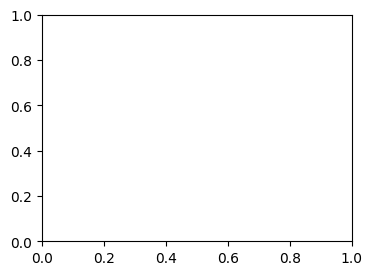

In [6]:
import tkinter as tk

root= tk.Tk()

fileName_var = tk.StringVar()
popNum_var = tk.StringVar()
shape_var = tk.StringVar()
actFunc_var = tk.StringVar()
genNum_var = tk.StringVar()
mutPrc_var = tk.StringVar()
SaveBest_var = tk.IntVar()


def hello ():
    data = np.genfromtxt(fileName_var.get(), delimiter=',')
    min_max_scaler = preprocessing.MinMaxScaler()
    cols = min_max_scaler.fit_transform(data[:,:8].T).T   # pierwsze 8 kolumn
    last_col = data[:,8]
    figure1 = plt.figure(figsize=(4,3), dpi=100) 
    subplot1 = figure1.add_subplot(111)
    tmpshape = shape_var.get().split(", ")
    shape = []
    if tmpshape != ['']:
        for num in tmpshape:
            shape.append(int(num))
    x, y, retText = GeneticAlgorithm(cols, last_col, int(popNum_var.get()), shape, actFunc_var.get(), int(genNum_var.get()), int(mutPrc_var.get()), bool(SaveBest_var.get()))
    subplot1.plot(x, y)
    subplot1.set_xlabel("Numer generacji")
    subplot1.set_ylabel("Procent poprawnie przewidzianych")
    subplot1.set_title("Postęp programu")
    plot = FigureCanvasTkAgg(figure1, root) 
    plot.get_tk_widget().grid(row = 7, column=0)
    text = tk.Text(root, height = 4, width=20)
    text.insert(tk.END, retText)
    text.grid(row = 7, column=1)
    

fileName_label = tk.Label(root, text = 'Nazwa pliku (wraz zrozszerzeniem)', font=('calibre',10, 'bold'))
fileName_entry = tk.Entry(root,textvariable = fileName_var, font=('calibre',10,'normal'))

popNum_label = tk.Label(root, text = 'Liczba osobników w populacji', font=('calibre',10, 'bold'))
popNum_entry = tk.Entry(root,textvariable = popNum_var, font=('calibre',10,'normal'))

shape_label = tk.Label(root, text = 'Warstwy ukryte, każda warstwa oddzielona \', \'', font=('calibre',10, 'bold'))
shape_entry = tk.Entry(root,textvariable = shape_var, font=('calibre',10,'normal'))

actFunc_label = tk.Label(root, text = 'Funkcja aktywacyjna(relu lub sigmoid)', font=('calibre',10, 'bold'))
actFunc_entry = tk.Entry(root,textvariable = actFunc_var, font=('calibre',10,'normal'))

genNum_label = tk.Label(root, text = 'Liczba generacji', font=('calibre',10, 'bold'))
genNum_entry = tk.Entry(root,textvariable = genNum_var, font=('calibre',10,'normal'))

mutPrc_label = tk.Label(root, text = 'Prawdopodobieństwo mutacji w procentach', font=('calibre',10, 'bold'))
mutPrc_entry = tk.Entry(root,textvariable = mutPrc_var, font=('calibre',10,'normal'))

c = tk.Checkbutton(root, text="Elitaryzm", variable=SaveBest_var, onvalue=1, offvalue=0)

fileName_label.grid(row=0, column =0)
fileName_entry.grid(row=0, column =1)
popNum_label.grid(row=1, column =0)
popNum_entry.grid(row=1, column =1)
shape_label.grid(row=2, column =0)
shape_entry.grid(row=2, column =1)
actFunc_label.grid(row=3, column =0)
actFunc_entry.grid(row=3, column =1)
genNum_label.grid(row=4, column =0)
genNum_entry.grid(row=4, column =1)
mutPrc_label.grid(row=5, column =0)
mutPrc_entry.grid(row=5, column =1)
c.grid(row=6, column = 0)

button1 = tk.Button(text='Submit',command=hello, bg='brown',fg='white')
button1.grid(row = 6, column = 1)

root.mainloop()